# Podstawy Sztucznej Inteligencji - Projekt Kacper Marzol

Celem tego projektu jest klasyfikacja piosenek na podstawie ich kilku cech. Zbiór danych składa się z 278 tysięcy piosenek z serwisu Spotify. Dla szybkości obliczeń, użyjemy 10% danych

In [21]:
import pandas as pd

data = pd.read_csv("278k_labelled_uri.csv")
data=data.iloc[:27800, :]
print(data.shape)
data.head()

(27800, 15)


,Unnamed: 0.1,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels,uri
0,0,0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2,spotify:track:3v6sBj3swihU8pXQQHhDZo
1,1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1,spotify:track:7KCWmFdw0TzoJbKtqRRzJO
2,2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1,spotify:track:2CY92qejUrhyPUASawNVRr
3,3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0,spotify:track:11BPfwVbB7vok7KfjBeW4k
4,4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1,spotify:track:3yUJKPsjvThlcQWTS9ttYx


In [22]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'duration (ms)', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'spec_rate', 'labels', 'uri'],
      dtype='object')

Acousticness: miara akustyczności od 0 do 1
Danceability: miara taneczności od 0 do 1
Energy: miara energiczności od 0 do 1
Instrumentalness: miara instrumentalności od 0 do 1
Liveness: miara obecności publiki w nagraniu od 0 do 1
Loudness: miara głośnośći w decybelach (-60 do 0 decybeli)
Speechiness: miara słów w piosence od 0 do 1
Valence: miara od 0 do 1 opisująca pozytywność przekazywaną przez piosenkę
Tempo: tempo piosenki w BMP (uderzeń na minutę)

In [23]:
data.labels.value_counts()

0    8707
1    8408
2    8201
3    2484
Name: labels, dtype: int64

0 - piosenka smutna
1 - piosenka wesoła
2 - piosenka energetyczna
3 - piosenka spokojna

Usuniemy zbędne kolumny, "uri", ponieważ URL piosenki nie jest potrzebny oraz dwie pierwsze kolumny

In [24]:
cols=["Unnamed: 0.1", "Unnamed: 0","uri"]
data=data.drop(cols ,axis=1)

In [25]:
data.head()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


Dodamy trochę nanów do zbioru

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

X = data.drop('labels', axis=1)
y = data.labels

ix = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    X.iat[row, col] = np.nan

X.isna().sum()

duration (ms)       2867
danceability        2767
energy              2797
loudness            2670
speechiness         2709
acousticness        2741
instrumentalness    2801
liveness            2806
valence             2799
tempo               2808
spec_rate           2815
dtype: int64

Podzielimy zbiór na część treningową, walidacyjną i testową:

In [27]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(X_val.shape)

(22240, 11)
(22240,)
(2780, 11)
(2780, 11)


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# xplot=X_train.iloc[:50, :]
# sns.pairplot(xplot)
# plt.show()

Nauczymy kilka modeli

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipeline = Pipeline([("imputer", SimpleImputer(strategy="median"))])

# Logistic Regression

In [30]:
models=[]
model_names=[]
accuracy=[]
f1=[]


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

def pipeline_maker(model):
    return make_pipeline(SimpleImputer(strategy="median"), StandardScaler(),model)

def test (model, param_grid_):
    pipe=pipeline_maker(model)
    search=GridSearchCV(pipe, param_grid=param_grid_,scoring='accuracy')
    search.fit(X_train, y_train)
    return search.best_estimator_, search.cv_results_

In [32]:
from sklearn.linear_model import LogisticRegression

logistic=LogisticRegression()

param_grid={
    'simpleimputer__strategy': ['mean', 'median'],
    "logisticregression__C": [0.0001,0.001,0.01,0.1,1,10,100,1000]
}

logistic, scores = test(logistic, param_grid)

results = pd.DataFrame(scores)

models.append(logistic)
model_names.append("Logistic Regression")
accuracy.append(accuracy_score(y_val,logistic.predict(X_val)))

In [33]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=10))])


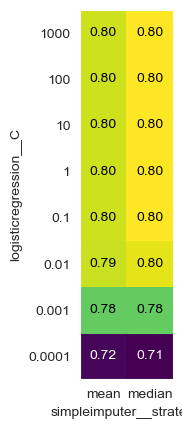

In [34]:
print(logistic)
scores = np.array(results.mean_test_score).reshape(8, 2, 1)
scores = scores[:,:,0]
# plot the mean cross-validation scores
heatmap(scores, xlabel='simpleimputer__strategy', xticklabels=param_grid['simpleimputer__strategy'], ylabel='logisticregression__C', yticklabels=param_grid['logisticregression__C'], cmap="viridis")
plt.show()

plt.show()

# Random Forests

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()

param_grid = {
    'randomforestclassifier__n_estimators': [10,20,30],
    'randomforestclassifier__max_depth': [None, 5, 10,15],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5]
}

rfc, scores = test(rfc, param_grid)

results = pd.DataFrame(scores)

models.append(rfc)
model_names.append("Random Forest Classifier")
accuracy.append(accuracy_score(y_val,rfc.predict(X_val)))

{'mean_fit_time': array([0.31055384, 0.55869846, 0.82867742, 0.28791471, 0.55444436,
       0.82345519, 0.28058634, 0.54593801, 0.81164565, 0.27609334,
       0.53693256, 0.78816457, 0.28018956, 0.54399018, 0.81723032,
       0.28162007, 0.54153214, 0.80656462, 0.27857838, 0.53694358,
       0.79554515, 0.26804705, 0.52450061, 0.77619939, 0.26558919,
       0.51302023, 0.76413827, 0.26624899, 0.51470938, 0.76068602,
       0.28615928, 0.52228336, 0.76418028, 0.2617979 , 0.50322075,
       0.75570798, 0.1700726 , 0.29563928, 0.439364  , 0.1399816 ,
       0.26769919, 0.41004243, 0.14110346, 0.27044206, 0.38830366,
       0.14885969, 0.26579494, 0.39133558, 0.14174714, 0.26925216,
       0.38990774, 0.1449553 , 0.26505413, 0.38335018, 0.14066229,
       0.26310878, 0.38391442, 0.14171   , 0.26123853, 0.38372335,
       0.13987284, 0.26278691, 0.38328176, 0.14197316, 0.26192794,
       0.38218803, 0.14013777, 0.26203914, 0.38003836, 0.1401052 ,
       0.26035299, 0.38212905, 0.22758107, 0